# Chance of admit prediction using linear regression

In this project we're going to use information like a student's gpa, gre, toefl, university ranking, etc. to predict the chance of admit. This kind of model is useful for graduate and undergraduate students. The dataset for this problem is taken from kaggle.


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model

In [244]:
# Uncomment and run the commands below if imports fail
!conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

Solving environment: done

# All requested packages already installed.



In [245]:
import torch
import numpy
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [246]:
project_name='04-Admission-linear-regression' # will be used by jovian.commit

In [247]:
dataframe=pd.read_csv(r'../input/graduate-admissions/Admission_Predict.csv')
dataframe.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65



#rows the dataset have?

In [248]:
num_rows = dataframe.shape[0]
print(num_rows)

400


#columns the dataset have

In [249]:
num_cols = dataframe.shape[1]
print(num_cols)

9


Column titles of the input variables?

In [250]:
input_cols = dataframe.columns.tolist()
input_cols.remove('Chance of Admit ')
input_cols

['Serial No.',
 'GRE Score',
 'TOEFL Score',
 'University Rating',
 'SOP',
 'LOR ',
 'CGPA',
 'Research']

In [251]:
categorical_cols = dataframe.select_dtypes(exclude=[numpy.number]).columns.tolist()
categorical_cols

[]

In [252]:
output_cols = ['Chance of Admit ']
output_cols

['Chance of Admit ']

In [253]:
!pip install matplotlib seaborn --upgrade --quiet

Minimum Chance of Admit: 
0.34
Maximum Price: 
0.97
Average: 
0.72435


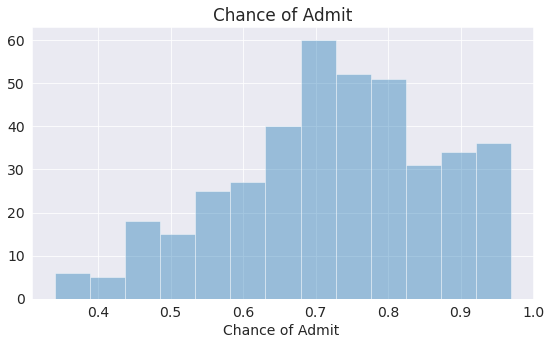

In [254]:
# Write your answer here
import statistics as sta
print('Minimum Chance of Admit: ')
print(min(dataframe['Chance of Admit ']))
print('Maximum Price: ')
print(max(dataframe['Chance of Admit ']))
print('Average: ')
print(sta.mean(dataframe['Chance of Admit ']))
# Plot
import seaborn as sns
import matplotlib
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
plt.title("Chance of Admit")
sns.distplot(dataframe['Chance of Admit '],kde=False);

In [255]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/diptakuet/04-Admission-linear-regression


<IPython.core.display.Javascript object>

## Step 2: Prepare the dataset for training


In [256]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [257]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[  1.  , 337.  , 118.  , ...,   4.5 ,   9.65,   1.  ],
        [  2.  , 324.  , 107.  , ...,   4.5 ,   8.87,   1.  ],
        [  3.  , 316.  , 104.  , ...,   3.5 ,   8.  ,   1.  ],
        ...,
        [398.  , 330.  , 116.  , ...,   4.5 ,   9.45,   1.  ],
        [399.  , 312.  , 103.  , ...,   4.  ,   8.78,   0.  ],
        [400.  , 333.  , 117.  , ...,   4.  ,   9.66,   1.  ]]),
 array([[0.92],
        [0.76],
        [0.72],
        [0.8 ],
        [0.65],
        [0.9 ],
        [0.75],
        [0.68],
        [0.5 ],
        [0.45],
        [0.52],
        [0.84],
        [0.78],
        [0.62],
        [0.61],
        [0.54],
        [0.66],
        [0.65],
        [0.63],
        [0.62],
        [0.64],
        [0.7 ],
        [0.94],
        [0.95],
        [0.97],
        [0.94],
        [0.76],
        [0.44],
        [0.46],
        [0.54],
        [0.65],
        [0.74],
        [0.91],
        [0.9 ],
        [0.94],
        [0.88],
        [0.64],
        [0.58],

In [258]:
inputs = torch.tensor(inputs_array,dtype=torch.float32)
targets = torch.tensor(targets_array,dtype=torch.float32)

In [259]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

In [260]:
dataset = TensorDataset(inputs, targets)

In [261]:
val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

# Use the random_split function to split dataset into 2 parts of the desired length
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size]) 


In [262]:
batch_size = 50

In [263]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [264]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[258.0000, 324.0000, 100.0000,   3.0000,   4.0000,   5.0000,   8.6400,
           1.0000],
        [294.0000, 312.0000,  98.0000,   1.0000,   3.5000,   3.0000,   8.1800,
           1.0000],
        [107.0000, 329.0000, 111.0000,   4.0000,   4.5000,   4.5000,   9.1800,
           1.0000],
        [ 59.0000, 300.0000,  99.0000,   1.0000,   3.0000,   2.0000,   6.8000,
           1.0000],
        [152.0000, 332.0000, 116.0000,   5.0000,   5.0000,   5.0000,   9.2800,
           1.0000],
        [143.0000, 331.0000, 115.0000,   5.0000,   4.0000,   3.5000,   9.4400,
           1.0000],
        [235.0000, 330.0000, 113.0000,   5.0000,   5.0000,   4.0000,   9.3100,
           1.0000],
        [ 15.0000, 311.0000, 104.0000,   3.0000,   3.5000,   2.0000,   8.2000,
           1.0000],
        [ 94.0000, 301.0000,  97.0000,   2.0000,   3.0000,   3.0000,   7.8800,
           1.0000],
        [138.0000, 316.0000, 100.0000,   2.0000,   1.5000,   3.0000,   8.1600,
           1.0000],
  

Let's save our work by committing to Jovian.

In [265]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/diptakuet/04-Admission-linear-regression


<IPython.core.display.Javascript object>

## Step 3: Create a Linear Regression Model

Our model is a linear regression model


In [266]:
input_size = len(input_cols)
output_size = len(output_cols)

In [267]:
class AdmissionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                         # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [268]:
model = AdmissionModel()

In [269]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.3022,  0.1366, -0.3177, -0.0692, -0.1945,  0.2377,  0.2378,  0.0378]],
        requires_grad=True),
 Parameter containing:
 tensor([0.1375], requires_grad=True)]

In [270]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/diptakuet/04-Admission-linear-regression


<IPython.core.display.Javascript object>

## Step 4: Train the model to fit the data


In [271]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [272]:
result =evaluate(model,val_loader) # Use the the evaluate function
print(result)

{'val_loss': 74.5477294921875}


In [273]:
epochs = 500
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 376.9975
Epoch [40], val_loss: 977.7545
Epoch [60], val_loss: 934.3533
Epoch [80], val_loss: 546.9971
Epoch [100], val_loss: 336.0945
Epoch [120], val_loss: 763.7101
Epoch [140], val_loss: 222.6034
Epoch [160], val_loss: 1101.1133
Epoch [180], val_loss: 827.7158
Epoch [200], val_loss: 703.7147
Epoch [220], val_loss: 957.1405
Epoch [240], val_loss: 1048.1721
Epoch [260], val_loss: 1283.9956
Epoch [280], val_loss: 1271.7449
Epoch [300], val_loss: 419.8943
Epoch [320], val_loss: 770.0304
Epoch [340], val_loss: 1070.0806
Epoch [360], val_loss: 938.7898
Epoch [380], val_loss: 292.4023
Epoch [400], val_loss: 1423.2002
Epoch [420], val_loss: 854.7737
Epoch [440], val_loss: 678.3290
Epoch [460], val_loss: 753.9878
Epoch [480], val_loss: 330.8630
Epoch [500], val_loss: 1442.2808


In [274]:
epochs = 1000
lr = 1e-4
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 4.7151
Epoch [40], val_loss: 8.0976
Epoch [60], val_loss: 11.8849
Epoch [80], val_loss: 7.9495
Epoch [100], val_loss: 4.3717
Epoch [120], val_loss: 7.2256
Epoch [140], val_loss: 7.0595
Epoch [160], val_loss: 7.1047
Epoch [180], val_loss: 5.2830
Epoch [200], val_loss: 8.0823
Epoch [220], val_loss: 6.8715
Epoch [240], val_loss: 7.9499
Epoch [260], val_loss: 8.7474
Epoch [280], val_loss: 8.7499
Epoch [300], val_loss: 7.6713
Epoch [320], val_loss: 9.9660
Epoch [340], val_loss: 9.2591
Epoch [360], val_loss: 9.9346
Epoch [380], val_loss: 5.1450
Epoch [400], val_loss: 4.2783
Epoch [420], val_loss: 10.6428
Epoch [440], val_loss: 5.2258
Epoch [460], val_loss: 10.9889
Epoch [480], val_loss: 6.1457
Epoch [500], val_loss: 6.7508
Epoch [520], val_loss: 7.6041
Epoch [540], val_loss: 4.4371
Epoch [560], val_loss: 6.4570
Epoch [580], val_loss: 9.9563
Epoch [600], val_loss: 7.2162
Epoch [620], val_loss: 6.5627
Epoch [640], val_loss: 3.7405
Epoch [660], val_loss: 6.2316
Epoch [680]

In [275]:
epochs = 1000
lr = 1e-4
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 5.7898
Epoch [40], val_loss: 7.7256
Epoch [60], val_loss: 7.0560
Epoch [80], val_loss: 8.5610
Epoch [100], val_loss: 9.6142
Epoch [120], val_loss: 6.4177
Epoch [140], val_loss: 6.4513
Epoch [160], val_loss: 8.4688
Epoch [180], val_loss: 5.5034
Epoch [200], val_loss: 9.6624
Epoch [220], val_loss: 10.4782
Epoch [240], val_loss: 6.7496
Epoch [260], val_loss: 4.7957
Epoch [280], val_loss: 6.7685
Epoch [300], val_loss: 8.6139
Epoch [320], val_loss: 8.8568
Epoch [340], val_loss: 11.6066
Epoch [360], val_loss: 7.6908
Epoch [380], val_loss: 3.2480
Epoch [400], val_loss: 10.5742
Epoch [420], val_loss: 8.7102
Epoch [440], val_loss: 6.5305
Epoch [460], val_loss: 7.9038
Epoch [480], val_loss: 9.9334
Epoch [500], val_loss: 11.7453
Epoch [520], val_loss: 6.1147
Epoch [540], val_loss: 6.0684
Epoch [560], val_loss: 8.3254
Epoch [580], val_loss: 8.4855
Epoch [600], val_loss: 7.9218
Epoch [620], val_loss: 5.8133
Epoch [640], val_loss: 9.4526
Epoch [660], val_loss: 6.7135
Epoch [680

In [276]:
epochs = 500
lr = 1e-3
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 123.1349
Epoch [40], val_loss: 69.8251
Epoch [60], val_loss: 90.7583
Epoch [80], val_loss: 62.3739
Epoch [100], val_loss: 79.0406
Epoch [120], val_loss: 133.8654
Epoch [140], val_loss: 69.8706
Epoch [160], val_loss: 22.7537
Epoch [180], val_loss: 41.7046
Epoch [200], val_loss: 56.8577
Epoch [220], val_loss: 57.3493
Epoch [240], val_loss: 73.8430
Epoch [260], val_loss: 62.6778
Epoch [280], val_loss: 59.5114
Epoch [300], val_loss: 86.1008
Epoch [320], val_loss: 71.5025
Epoch [340], val_loss: 53.6425
Epoch [360], val_loss: 96.7346
Epoch [380], val_loss: 74.2210
Epoch [400], val_loss: 73.5651
Epoch [420], val_loss: 76.3125
Epoch [440], val_loss: 77.5487
Epoch [460], val_loss: 144.0900
Epoch [480], val_loss: 131.8213
Epoch [500], val_loss: 98.7864


In [277]:
epochs = 500
lr = 1e-5
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 1.0565
Epoch [40], val_loss: 0.9002
Epoch [60], val_loss: 0.8938
Epoch [80], val_loss: 0.8895
Epoch [100], val_loss: 0.8931
Epoch [120], val_loss: 0.8647
Epoch [140], val_loss: 0.8614
Epoch [160], val_loss: 0.8464
Epoch [180], val_loss: 0.8414
Epoch [200], val_loss: 0.8525
Epoch [220], val_loss: 0.8678
Epoch [240], val_loss: 0.8659
Epoch [260], val_loss: 0.8098
Epoch [280], val_loss: 0.8195
Epoch [300], val_loss: 0.7936
Epoch [320], val_loss: 0.8155
Epoch [340], val_loss: 0.7758
Epoch [360], val_loss: 0.8012
Epoch [380], val_loss: 0.8004
Epoch [400], val_loss: 0.8216
Epoch [420], val_loss: 0.7799
Epoch [440], val_loss: 0.7383
Epoch [460], val_loss: 0.7754
Epoch [480], val_loss: 0.7390
Epoch [500], val_loss: 0.7412


the final validation loss:  0.7411876916885376


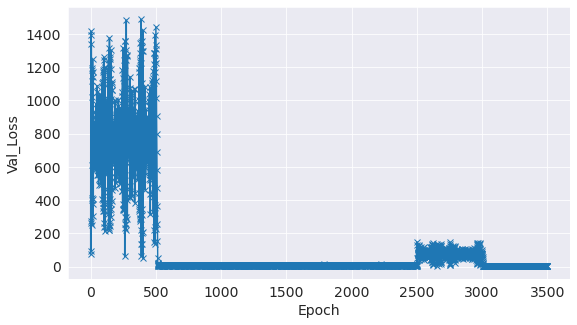

In [278]:
history = [result] + history1 + history2 + history3 + history4 + history5
val_loss = [result['val_loss'] for result in history]
plt.plot(val_loss,'-x')
plt.xlabel('Epoch')
plt.ylabel('Val_Loss')
print('the final validation loss: ',val_loss[len(val_loss)-1])

In [279]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [280]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/diptakuet/04-Admission-linear-regression


<IPython.core.display.Javascript object>

## Step 5: Make predictions using the trained model

In [281]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)              # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [282]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([367.0000, 320.0000, 104.0000,   3.0000,   3.5000,   4.5000,   8.3400,
          1.0000])
Target: tensor([0.7400])
Prediction: tensor([1.6181])


In [283]:
input, target = val_ds[2]
predict_single(input, target, model)

Input: tensor([218.0000, 321.0000, 109.0000,   4.0000,   4.0000,   4.0000,   9.1300,
          1.0000])
Target: tensor([0.8500])
Prediction: tensor([0.5008])


In [284]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([214.0000, 333.0000, 119.0000,   5.0000,   5.0000,   4.5000,   9.7800,
          1.0000])
Target: tensor([0.9600])
Prediction: tensor([-1.1442])


In [285]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/diptakuet/04-Admission-linear-regression


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/diptakuet/04-Admission-linear-regression


<IPython.core.display.Javascript object>